##Essential Information Enhanced Fact-Checking on FEVER dataset.

In this assignment we are going to perform the Essential Information Enhanced Fact-Checking task over the FEVER(Fact Extraction and VERification) dataset, using various binary classification transformer models and Evaluate the insertion of the <hl> tags on this binary classification task. The FEVER dataset consists of 185,445 claims generated by altering sentences extracted from Wikipedia. The claims are classified as Supported, Refuted or NotEnoughInfo. For the first two classes, the annotators also recorded the sentence(s) forming the necessary evidence for their judgment. Our dataset consists of the following columns:

claim: The text of the claim.

evidence: A list of evidence sets (lists of [Annotation ID, Evidence ID, Wikipedia URL, sentence ID] tuples) or a [Annotation ID, Evidence ID, null, null] tuple if the label is NOT ENOUGH INFO.

id: The ID of the claim.

label: The annotated label for the claim. Can be one of SUPPORTS | REFUTES | NOT ENOUGH INFO.

# Install Dependencies

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import TensorDataset
from google.colab import drive
import os
import requests
#from datasets import Dataset as ds ,load_metric
import torch
import zipfile
import pandas as pd
import numpy as np
import json
import random
from tqdm import tqdm
from typing import List
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
import warnings
warnings.filterwarnings('ignore')
from transformers import AutoConfig, AutoTokenizer, AutoModelForSequenceClassification, get_cosine_schedule_with_warmup

# Data preparation

Data preparation

In this section we are going to simply download the FEVER dataset and store it in a local folder. I have already downloaded the dataset from their site https://fever.ai/dataset/fever.html and stored it in the drive. I am loading the train, validation and test dataset and evidence dataset that contains the evidences that are associated with each claim.

In [ ]:
#@title Load data from drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
scifactDataTrain = pd.read_json('/content/drive/MyDrive/Datasets/fever/train.jsonl', lines=True)
scifactDataVal = pd.read_json('/content/drive/MyDrive/Datasets/fever/paper_dev.jsonl', lines=True)
scifactDataTest = pd.read_json('/content/drive/MyDrive/Datasets/fever/paper_test.jsonl', lines=True)

LOADING THE DATASETS CONTAINING THE EVIDENCE DATA AND MERGING THEM IN A SINGLE DATASET AND UPLAODING IT ON THE DRIVE. I AM DOING THIS BECAUSE THESE DATASETS ARE VERY HUGE IN SIZE AND THEY REQUIRE A LOT OF TIME TO LOAD. AFTER MERGING THEM TO A SINGLE FILE, I USE THIS CSV EVERYTIME I WANT TO LOAD THE DATA. ALSO, I AM TAKING ONLY THE 50 EVIDENCE FILES WHILE AS IN ACTUAL THEY ARE 100, THE REASON IS AGAIN DUE TO HUGE SIZE OF DATA, MY SYSTEM CRASHES. HENCE, I DECIDED TO TAKE HALF OF THE DATA.

In [ ]:
wiki =  pd.read_json('/content/drive/MyDrive/Datasets/fever/WikiPages/wiki-pages.zip (Unzipped Files)/wiki-pages/wiki-001.jsonl', lines=True)
for i in range(2, 10):
  name = '/content/drive/MyDrive/Datasets/fever/WikiPages/wiki-pages.zip (Unzipped Files)/wiki-pages/wiki-00'+str(i)+'.jsonl'
  wikiNext = pd.read_json(name, lines=True)
  wiki = wiki.append(wikiNext, ignore_index=True)
for i in range(10, 51):
  name = '/content/drive/MyDrive/Datasets/fever/WikiPages/wiki-pages.zip (Unzipped Files)/wiki-pages/wiki-0'+str(i)+'.jsonl'
  wikiNext = pd.read_json(name, lines=True)
  wiki = wiki.append(wikiNext, ignore_index=True)

In [ ]:
#SAVING THE DATAFRAMES TO A SINGLE FILE. THIS IS DONE ONLY ONCE.
wiki.to_csv('/content/drive/MyDrive/wikipagesmerge.csv', index=False)

In [ ]:
#LOAD THE SAVED DATAFRAME CONTAINING THE MERGED EVIDENCES FROM THE DRIVE.
wikidf = pd.read_csv('/content/drive/MyDrive/wikipagesmerge.csv')

In [ ]:
wikidf.shape

(2500000, 3)

In [ ]:
scifactDataVal.head()

,id,verifiable,label,claim,evidence
0,91198,NOT VERIFIABLE,NOT ENOUGH INFO,Colin Kaepernick became a starting quarterback...,"[[[108548, None, None, None]]]"
1,194462,NOT VERIFIABLE,NOT ENOUGH INFO,Tilda Swinton is a vegan.,"[[[227768, None, None, None]]]"
2,137334,VERIFIABLE,SUPPORTS,Fox 2000 Pictures released the film Soul Food.,"[[[289914, 283015, Soul_Food_-LRB-film-RRB-, 0..."
3,166626,NOT VERIFIABLE,NOT ENOUGH INFO,Anne Rice was born in New Jersey.,"[[[191656, None, None, None], [191657, None, N..."
4,111897,VERIFIABLE,REFUTES,Telemundo is a English-language television net...,"[[[131371, 146144, Telemundo, 0]], [[131371, 1..."


We see above that we have a datframe with 5 columns. The claim column contains the claim that has been made and the evidence column is a list that contains the information in the form of list of all the evidences that assist the label that is attached to that claim. It is quite noting that the data above doesn't contain the actual evidence text but it only contains the information about the evidence. Actual evidence text are in our wiki dataframe and further in the program, we get the evidence text for each of the claims mentioned above.

In [ ]:
#Check if any evidence column is NUll. If yes then drop them
scifactDataTrain[scifactDataTrain["evidence"].str.len() == 0]

,id,verifiable,label,claim,evidence


I check the unique values associated to each sentence label and I see that there are 3 label classes available. that are, 'NOT ENOUGH INFO', 'SUPPORTS', 'REFUTES'. I remove the rows with label = 'NOT ENOUGH INFO' as such rows have no evidences associated with them and we don't require such rows in our model.

In [ ]:
scifactDataVal["label"].unique()

#We see that here, the label has 3 values, i.e, 'SUPPORTS', 'REFUTES', 'NOT ENOUGH INFO'. So we will drop the rows with value 'NOT ENOUGH INFO'.

array(['NOT ENOUGH INFO', 'SUPPORTS', 'REFUTES'], dtype=object)

In [ ]:
#Drop the rows with label column value = 'NOT ENOUGH INFO'
scifactDataTrain = scifactDataTrain[scifactDataTrain.label != 'NOT ENOUGH INFO']
scifactDataVal = scifactDataVal[scifactDataVal.label != 'NOT ENOUGH INFO']

In [ ]:
scifactDataTrain["label"].unique()
#We see that the label value 'NOT ENOUGH INFO' has been reoved from the label option.

array(['SUPPORTS', 'REFUTES'], dtype=object)

Initialising the variables required to add the tags in the rationale sentences. Set add_sentence_tags = True (In case we want to add the tags).

In [ ]:
add_sentence_tags = False #SET THIS TO TRUE IF YOU WANT TO ADD THE <hl> TAGS.
tag_start = '<hl>'
tag_end = '<\hl>'

In the following cells, I take the dataset and attach the additional column of evidence_text to each row, which is actually the text that supports/refutes the given claim. I make the two datasets, one is with the evidence containing tags( that is, the <hl> tags associated with the rationale of each evidence text) and other is without the tags. Both of these datsets are stored in the drive. I do this so I can just load the dataset(that contains the evidence text) everytime I need it.

Adding function to add a new column to the dataframe that contains the evidence text along with the tags to the rationale sentences(in case we set add_sentence_tags =True ). This is done only once to save the data to the drive.

In [ ]:
scifactDataVal_subset = scifactDataVal[:3000]
scifactDataVal_subset['evidence_text'] = scifactDataVal_subset.apply(addEvidenceTextTest, axis=1)

In [ ]:
scifactDataVal_subset = scifactDataVal_subset[scifactDataVal_subset['evidence_text'] != ""]
scifactDataVal_subset.to_csv('/content/drive/MyDrive/feverSubsetWithoutTags.csv', index=False)

In [ ]:
#Adding additional column to my model the evidence text associated to each claim.
def addEvidenceTextTest(row: pd.Series) -> str:

    evidence_sentence_pair = {}
    abstract = ""
    for i, annotation in enumerate(row.evidence):
      for j, evidence in enumerate(annotation):
          if len(evidence) >= 3:
            if evidence[2] not in evidence_sentence_pair:
              evidence_sentence_pair[evidence[2]] = [evidence[3]]
            else:
              evidence_sentence_pair[evidence[2]].append(evidence[3])
    for key, values in evidence_sentence_pair.items():
        wikiEvidence = wikidf.loc[wikidf['id'] == key, 'lines']   
        if(wikiEvidence.shape[0] != 0):
            evidence_text_list = wikiEvidence.iloc[0].split("\n")
            #Uncomment this code when we want to add tags in the dataset.
            # for sentence_id in values:
            #   evidence_text_list[sentence_id] = tag_start + evidence_text_list[sentence_id] + tag_end
            abstract += str(evidence_text_list)
    return abstract

Loading the datasets(containing the evidence text) from the drive. It should be noted that one datasets evidence texts contains the tags and other do not. We load the desired dataset by setting the set_tags_in_evidence variable to true or false.This variable is also used further in loading the model. So, this single variable controls if tags are used or not in the evidence texts of the training data.

In [ ]:
set_tags_in_evidence = False
if(set_tags_in_evidence == True):
  feverdata = pd.read_csv('/content/drive/MyDrive/feverSubsetWithTags.csv')
else:
  feverdata = pd.read_csv('/content/drive/MyDrive/feverSubsetWithoutTags.csv')

Divide the dataset into train, validation and test. I am using a small dataset in order to not get the memory overflow issues.

In [ ]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(feverdata, test_size=0.14, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.16, random_state=42)

print("Train set shape:", train_df.shape)
print("Validation set shape:", val_df.shape)
print("Test set shape:", test_df.shape)

Train set shape: (1055, 6)
Validation set shape: (201, 6)
Test set shape: (205, 6)


# Model Definition and Training

Initialising the arguments for the model and loading the model. I am using the smaller batch_size = 4 in order to prevent the memory overflow issues.

I am using 4 base models to train the data which are:

* RoBERTa.

* BERT.
* BART.
* SciBERT.

Each model is run two times. One for the usual FEVER dataset and other for the FEVER dataset with <h> tags in the evidence sentences that support/contradict the claim.

We do this because we want to see the difference that the insertion of <h> tags do on our classification task and we want to compare the models.

I am considering the following metrics:

* Accuracy
* Precision
* Recall
* F1-Score
* Macro-F1

In [ ]:
args = {
    # 'model_name' : 'roberta-large',
    'model_name' : 'bert-base-uncased',
    #'model_name' : 'facebook/bart-base',
    #'model_name' : 'allenai/scibert_scivocab_uncased',
    'lr_base' : 1e-5,
    'lr-linear' : 1e-4,
    'batch_size' : 4,
    'epochs' : 10,
    'batch_size_accumulated' : 256, #The batch size for each gradient update.
}

In the cell below, I am initialising the tokenizer and the model. When the set_tags_in_evidence variable is set to True, it means there are <h> tags in our dataset and the model is asked learn these additional tags/tokens.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device "{device}"')
tokenizer = AutoTokenizer.from_pretrained(args['model_name'])
if(set_tags_in_evidence == True):
  special_tokens_dict = ['<hl>', '<\hl>','<\\hl>']
  num_added_toks = tokenizer.add_tokens(special_tokens_dict)
config = AutoConfig.from_pretrained(args['model_name'], num_labels=2)
model = AutoModelForSequenceClassification.from_pretrained(args['model_name'], config=config).to(device)
if(set_tags_in_evidence == True):
  model.resize_token_embeddings(len(tokenizer))


if(args['model_name'] == 'roberta-large'):
# If you are using non-roberta based models, change this to point to the right base
  params= [{'params': model.roberta.parameters(), 'lr': args['lr_base']},
  {'params': model.classifier.parameters(), 'lr': args['lr-linear']}]
else:
  params = [{'params': model.parameters(), 'lr': args['lr_base']},]

optimizer = torch.optim.Adam(
    params
)
scheduler = get_cosine_schedule_with_warmup(optimizer, 0, 20)

Using device "cuda"


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Tokenize and prepare for the model a list of sequences or a list of pairs of sequences.

Returns input_ids -- List of token ids to be fed to a model, token_type_ids and attention_mask.

In [ ]:
def encode(claims: List[str], evidence_text: List[str]):
    encoded_dict = tokenizer.batch_encode_plus(
        list(zip(evidence_text, claims)),
        max_length = 512,
        padding=True,
        return_tensors='pt',
        add_special_tokens = True,
        truncation_strategy='only_first',     
        )
    encoded_dict = {key: tensor.to(device) for key, tensor in encoded_dict.items()}
    return encoded_dict

Writing function to evaluate the model.

In [ ]:
def evaluate(model, dataset):
    # model.eval()
    
    targets = []
    outputs = []
    with torch.no_grad():
        for batch in DataLoader(dataset, batch_size=args['batch_size']):
            encoded_dict = encode(batch['claim'], batch['evidence_text'])
            logits = model(**encoded_dict)[0]
            targets.extend(batch['label'].float().tolist())
            outputs.extend(logits.argmax(dim=1).tolist())
    return {
        'macro_f1': f1_score(targets, outputs, zero_division=0, average='macro'),
        'f1': f1_score(targets, outputs),
        'precision': precision_score(targets, outputs),
        'recall': recall_score(targets, outputs),
        'accuracy' : accuracy_score(targets, outputs)
    }

Creating a custom DataLoader class to load the data.

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, dataframe):
        #convert evidence_text list into string
        self.dataframe = dataframe
        self.samples = []
        label_encodings = {'REFUTES': 0, 'SUPPORTS': 1}
        for index, row in self.dataframe.iterrows():
          self.samples.append({
                          'claim': row['claim'],
                          'evidence_text' : row["evidence_text"],
                          'label': label_encodings[row['label']]
                      })

    def __len__(self):
         return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]
          

In [ ]:
train_dataset = CustomDataset(train_df)
Val_dataset = CustomDataset(val_df)
test_dataset = CustomDataset(test_df)

TRAIN AND EVALUATE THE MODEL

In [ ]:
torch.cuda.empty_cache()
for e in range(args['epochs']):
      model.train()
      t = tqdm(DataLoader(train_dataset, batch_size=args['batch_size'], shuffle=False))
      for i, batch in enumerate(t):
        encoded_dict = encode(batch['claim'], batch['evidence_text'])
        output = model(**encoded_dict, labels=batch['label'].long().to(device))
        loss = output.loss
        logits = output.logits
        loss.backward()
        if (i + 1) % (args['batch_size_accumulated'] // args['batch_size']) == 0:
            optimizer.step()
            optimizer.zero_grad()
            t.set_description(f'Epoch {e}, iter {i}, loss: {round(loss.item(), 4)}')
      scheduler.step()
# Eval
train_score = evaluate(model, train_dataset)
print('Train score:')
print(train_score)
dev_score = evaluate(model, Val_dataset)
print('Dev score:')
print(dev_score)
test_score = evaluate(model, test_dataset)
print('Test score:')
print(test_score)
# Save
save_path = os.path.join("/content/drive/MyDrive", f'FEVERwithoutHtagBERT')
os.makedirs(save_path)
tokenizer.save_pretrained(save_path)
model.save_pretrained(save_path)

Epoch 9, iter 255, loss: 0.4034: 100%|██████████| 264/264 [01:47<00:00,  2.45it/s]


Train score:
{'macro_f1': 0.8426369210641709, 'f1': 0.8409961685823755, 'precision': 0.8442307692307692, 'recall': 0.8377862595419847, 'accuracy': 0.842654028436019}
Dev score:
{'macro_f1': 0.6750404178584755, 'f1': 0.6976744186046513, 'precision': 0.7352941176470589, 'recall': 0.6637168141592921, 'accuracy': 0.6766169154228856}
Test score:
{'macro_f1': 0.6874404421574233, 'f1': 0.6767676767676768, 'precision': 0.6767676767676768, 'recall': 0.6767676767676768, 'accuracy': 0.6878048780487804}


# Problem Statement

Our Problem is the classification problem. We are given the claim and the evidence and we have to check if the given evidence supports or contradicts our claim. The output of the model is either SUPPORTS or REFUTES. That means our evidence will either support the claim or it will refute/contradict the claim. Below is the given example of our dataset.

In [ ]:
feverdata.iloc[3]

id                                                          204361
verifiable                                              VERIFIABLE
label                                                     SUPPORTS
claim                                        The Cretaceous ended.
evidence         [[[241287, 242825, 'Cretaceous', 8]], [[241288...
evidence_text    ['0\tThe Cretaceous -LRB- -LSB- pronkrᵻˈteɪʃəs...
Name: 3, dtype: object

In [ ]:
feverdata.iloc[3].claim

'The Cretaceous ended.'

The above cell shows one of the claims that we have to verify.

In [ ]:
feverdata.iloc[3].evidence_text

"['0\\tThe Cretaceous -LRB- -LSB- pronkrᵻˈteɪʃəs -RSB- , -RRB- is a geologic period and system that spans 79 million years from the end of the Jurassic Period million years ago -LRB- Mya -RRB- to the beginning of the Paleogene Period Mya .\\tgeologic period and system\\tgeologic period\\tJurassic\\tJurassic\\tMya\\tannum\\tPaleogene\\tPaleogene', '1\\tIt is the last period of the Mesozoic Era .\\tMesozoic Era\\tMesozoic Era', '2\\tThe Cretaceous Period is usually abbreviated K , for its German translation Kreide -LRB- chalk -RRB- .\\tGerman\\tGerman language', '3\\t', '4\\t', '5\\tThe Cretaceous was a period with a relatively warm climate , resulting in high eustatic sea levels that created numerous shallow inland seas .\\tclimate\\tclimate\\teustatic sea levels\\tSea level#Local and eustatic\\tinland seas\\tInland sea (geology)', '6\\tThese oceans and seas were populated with now-extinct marine reptiles , ammonites and rudists , while dinosaurs continued to dominate on land .\\textinc

The above cell contains the evidence of the claim and this evidence will either contradict/refute or support the above mentioned claim.

In [ ]:
feverdata.iloc[3].label

'SUPPORTS'

The label column in our dataset tells us if the claim is supported or refuted/contradicted by the evidence. We see above that the label column tells that the evidence SUPPORTS the claim.

In [ ]:
feverdata.iloc[3].evidence

"[[[241287, 242825, 'Cretaceous', 8]], [[241288, 242826, 'Cretaceous', 8]], [[241288, 242827, 'Cretaceous', 9]], [[241289, 242828, 'Cretaceous', 8]], [[241289, 242829, 'Cretaceous', 9]]]"

The above column of evidence contains the sentence numbers of evidence_text that actually supports the claim. These sentences are tagged by \<hl\> tags for the models which contains tags.

The above four cells define our problem statement and the dataset.

Our task is to create the classification model for the above problem and then add the \<hl\> tags to the sentences that actually supports/contradicts the claim (in the evidence) and finally see the difference between the models. We want to check if our model has actually learned something when we add the \<hl\> tags while training or not. Below are the results of all the models for their respective test and validation set.

# Results

In total, I have trained 8 models on our dataset. 4 models for the train dataset that do not contain the <hl> tags and 4 models for the train dataset that contains the <hl> tags.

Following are the results of all the models of their respective test set scores and validation set scores.

There are 3 columns for each dataset score.

1. **The first column contains the results of test/validation score when the model was trained without <hl> tags.**

2. **The second column shows the results when the model was trained with <hl> tags but no tags were present in the test set and the validation set during model evaluation.**

3. **The third column shows the scores of a model that was trained with the <hl> tags and these tags were also present in the validation and test sets during model evaluation.** 

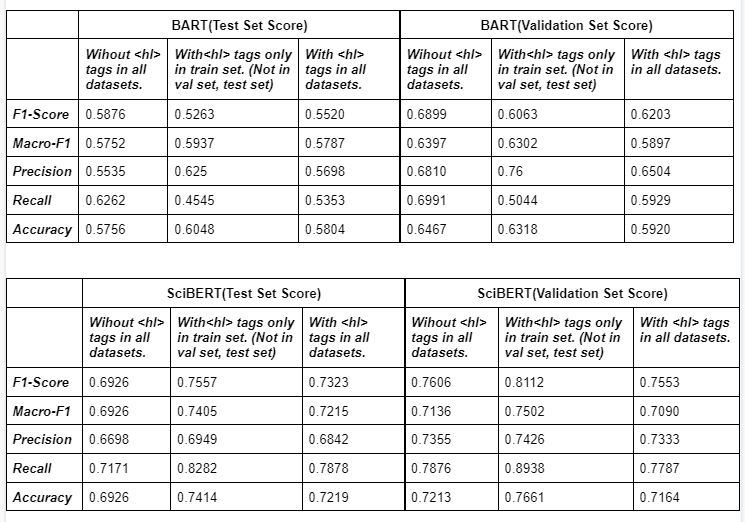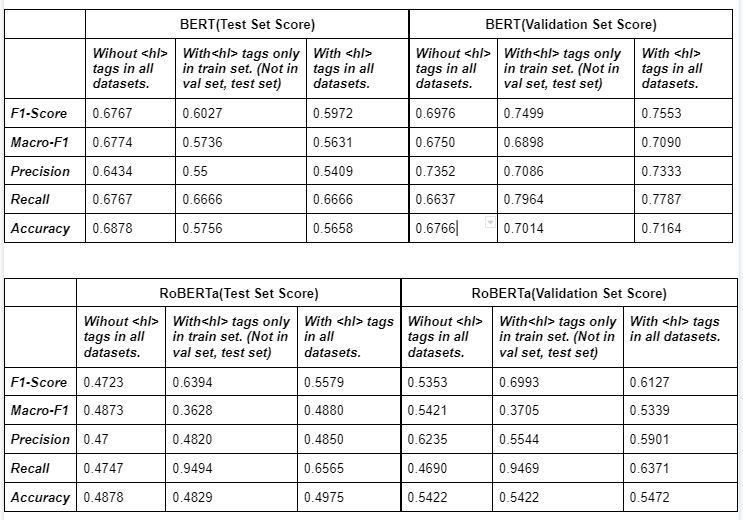

From the above results, we can see that our technique of adding the tags to the evidence sentences that support/contradict the claim is useful for example comparing the accuracy SciBERT witout having tags is 69.26% while the same model have the accuracy of 74.14% when the tags are added to the evidence text(during training). The improvement is also seen in the other models such as RoBERTa and BART and BERT. This means that our model is learning from the tags and when we pass the test set that doesn't contain the tags, the accuracy of the model is still increased. Hence, our technique is working.

# CODE TO LOAD THE SAVED MODEL

CODE TO LOAD THE SAVED MODEL FROM THE DRIVE TO RECREATE THE RESULTS.

In [ ]:
newModel = AutoModelForSequenceClassification.from_pretrained("/content/drive/MyDrive/FEVERwithHtagROBERTAepoch-9-f1-6127").to(device)
tokenizer = AutoTokenizer.from_pretrained("/content/drive/MyDrive/FEVERwithHtagROBERTAepoch-9-f1-6127")

In [ ]:
Val_score_new = evaluate(newModel, Val_dataset)
test_score_new = evaluate(newModel, test_dataset)
print(test_score_new)
print(Val_score_new)

{'macro_f1': 0.3628313394323247, 'f1': 0.6394557823129252, 'precision': 0.48205128205128206, 'recall': 0.9494949494949495, 'accuracy': 0.48292682926829267}
{'macro_f1': 0.3705065359477123, 'f1': 0.699346405228758, 'precision': 0.5544041450777202, 'recall': 0.9469026548672567, 'accuracy': 0.5422885572139303}
